In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

spark = SparkSession.builder \
    .appName("Silver-Visualization") \
    .config("spark.local.dir", "/spark_temp")\
    .config("spark.driver.memory", "2g") \
    .config("spark.ui.showConsoleProgress", "false") \
    .getOrCreate()


In [5]:
silver_path = "./parquet" 

print(f"Lendo o Joined da Camada Silver de: {silver_path}")
df_joined = spark.read.parquet(silver_path)

df_joined.persist()
print("DataFrame Silver carregado e persistido.")
df_joined.printSchema()

Lendo o Joined da Camada Silver de: ./parquet
DataFrame Silver carregado e persistido.
root
 |-- accident_index: string (nullable = true)
 |-- vehicle_reference: integer (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- accident_severity: integer (nullable = true)
 |-- number_of_vehicles: integer (nullable = true)
 |-- number_of_casualties: integer (nullable = true)
 |-- accident_timestamp: date (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- accident_time: string (nullable = true)
 |-- road_type: integer (nullable = true)
 |-- speed_limit: integer (nullable = true)
 |-- junction_detail: integer (nullable = true)
 |-- junction_control: integer (nullable = true)
 |-- pedestrian_crossing_physical_facilities: integer (nullable = true)
 |-- light_conditions: integer (nullable = true)
 |-- weather_conditions: integer (nullable = true)
 |-- road_surface_conditions: integer (nullable = true)
 |-- special_conditions_at_si

### Grafico Quantidade de Acidentes por severidade

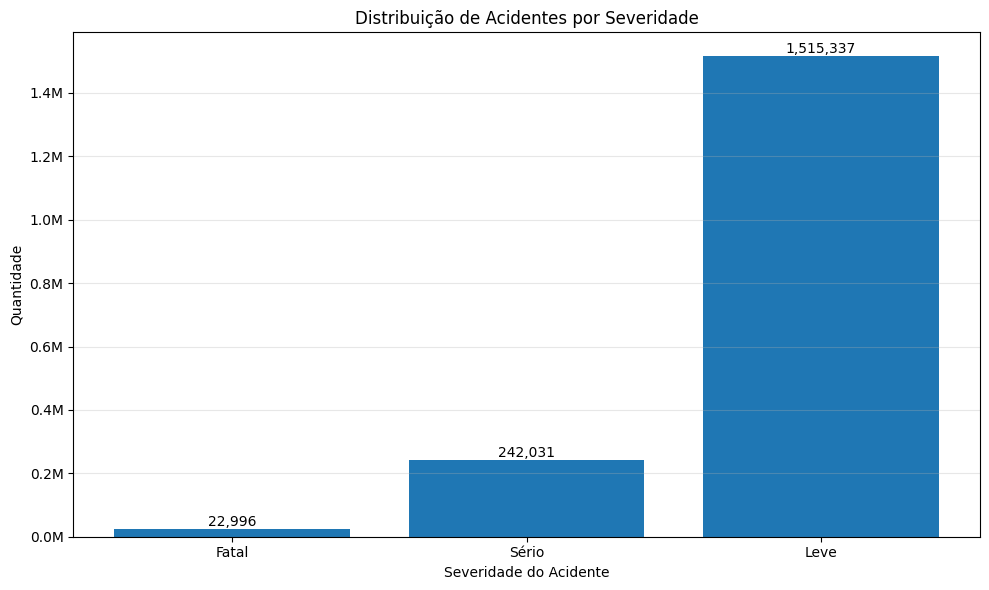

In [7]:
accident_severity = df_joined.select("accident_index", "accident_severity").distinct().groupBy("accident_severity").count().orderBy("accident_severity").toPandas()

severity_map = {1: 'Fatal', 2: 'Sério', 3: 'Leve'}
accident_severity['Severity_Label'] = accident_severity['accident_severity'].map(severity_map)

plt.figure(figsize=(10, 6))
bars = plt.bar(accident_severity['Severity_Label'], accident_severity['count'])

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:,.0f}',
             ha='center', va='bottom')

plt.xlabel("Severidade do Acidente")
plt.ylabel("Quantidade")
plt.title("Distribuição de Acidentes por Severidade")

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{x/1e6:.1f}M'))

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### Acidentes por dia da semana

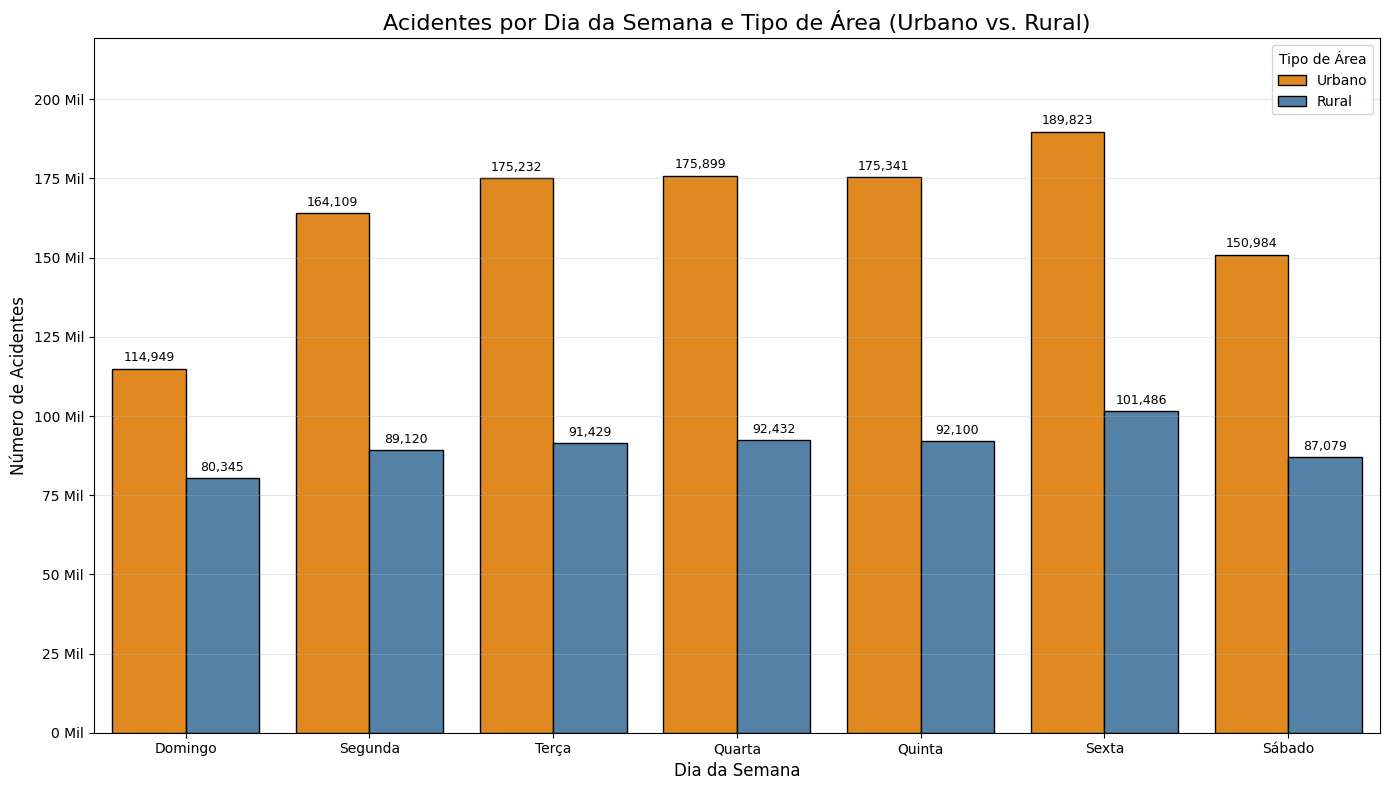

In [8]:
df_day_area_agg = df_joined \
    .select("accident_index", "day_of_week", "urban_or_rural_area") \
    .distinct() \
    .groupBy("day_of_week", "urban_or_rural_area") \
    .count() \
    .orderBy("day_of_week", "urban_or_rural_area")

pd_day_area = df_day_area_agg.toPandas()

days_map = {1: 'Domingo', 2: 'Segunda', 3: 'Terça', 4: 'Quarta', 5: 'Quinta', 6: 'Sexta', 7: 'Sábado'}
area_map = {1: 'Urbano', 2: 'Rural', 3: 'Não Alocado'}
pd_day_area['Dia_Semana'] = pd_day_area['day_of_week'].map(days_map)
pd_day_area['Tipo_Area'] = pd_day_area['urban_or_rural_area'].map(area_map)

pd_plot_data = pd_day_area[pd_day_area['Tipo_Area'] != 'Não Alocado'].dropna()

plt.figure(figsize=(14, 8))


ax = sns.barplot(
    data=pd_plot_data,
    x="Dia_Semana",
    y="count",
    hue="Tipo_Area",
    palette={"Urbano": "darkorange", "Rural": "steelblue"},
    edgecolor="black"
)

for container in ax.containers:
    ax.bar_label(
        container, 
        fmt='{:,.0f}',
        fontsize=9,
        padding=3
    )

plt.xlabel('Dia da Semana', fontsize=12)
plt.ylabel('Número de Acidentes', fontsize=12)
plt.title('Acidentes por Dia da Semana e Tipo de Área (Urbano vs. Rural)', fontsize=16)
plt.legend(title="Tipo de Área")
plt.grid(True, alpha=0.3, axis='y')

from matplotlib.ticker import FuncFormatter
def thousands_formatter(x, pos):
    return f'{x/1e3:.0f} Mil'
plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

current_ylim = plt.ylim()
plt.ylim(current_ylim[0], current_ylim[1] * 1.1) 

plt.tight_layout()
plt.show()

### Heatmap de Acidentes por Hora do Dia

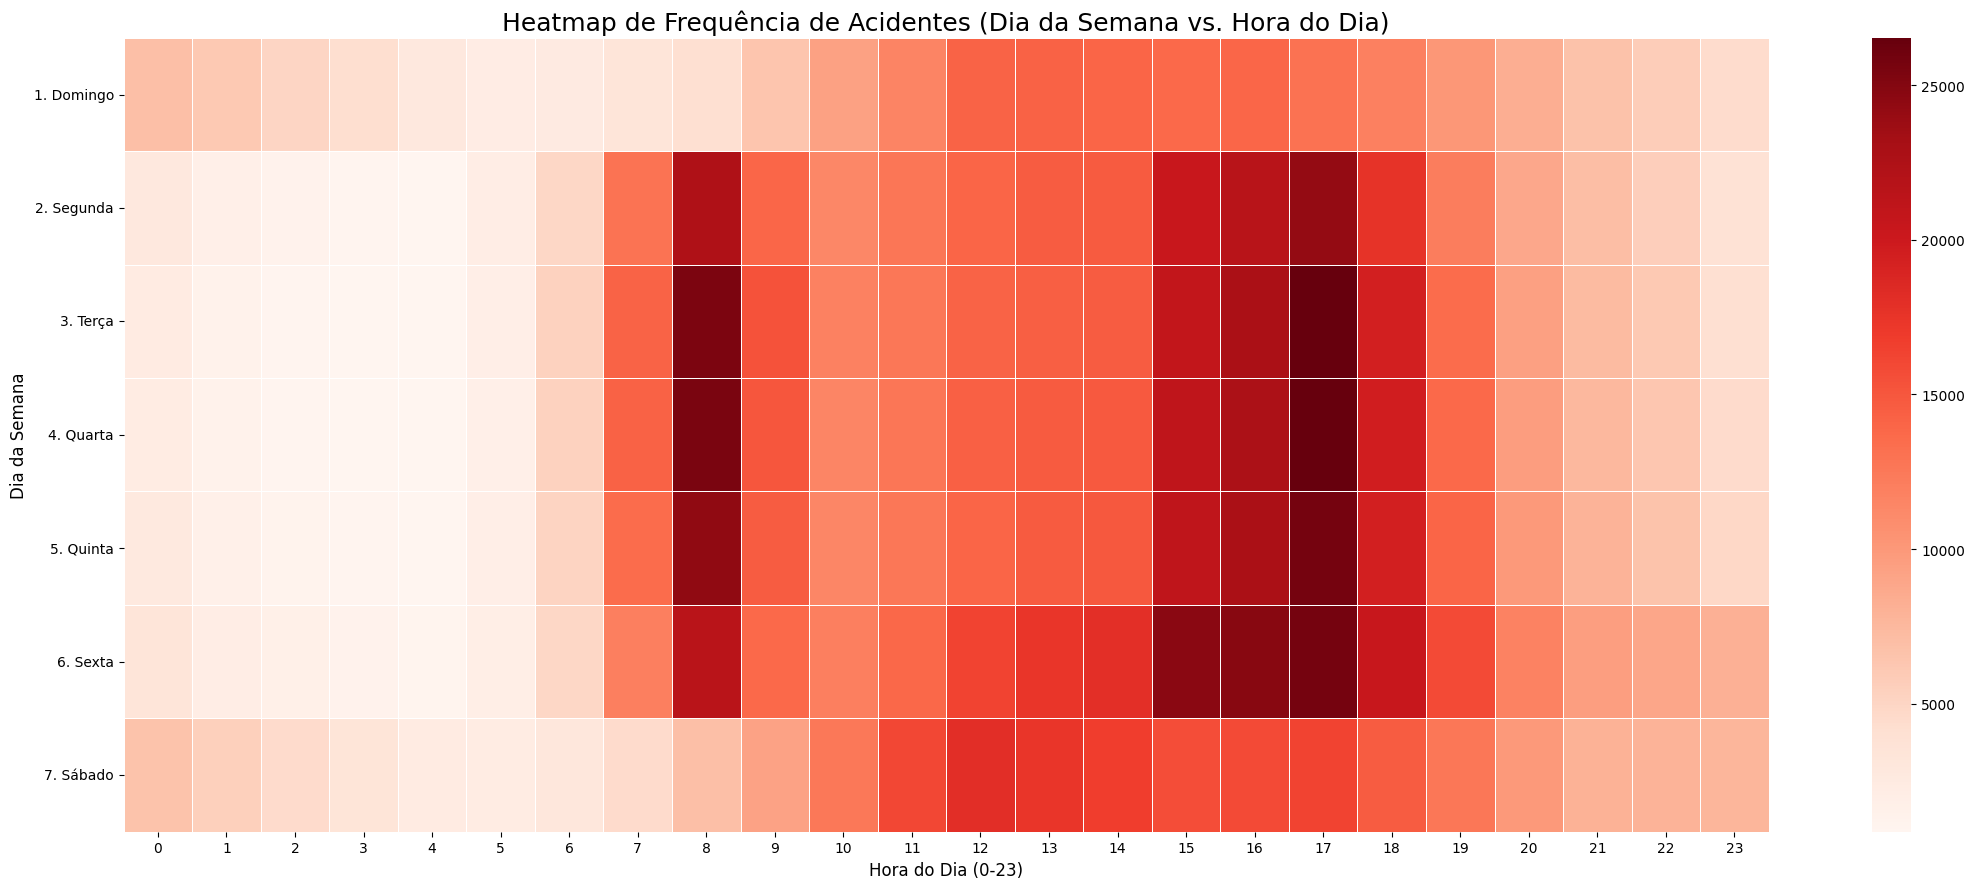

In [9]:
df_time_agg = df_joined \
    .select("accident_index", "day_of_week", "accident_time") \
    .distinct() \
    .withColumn(
        "Hour_of_Day",
        F.hour( F.to_timestamp(F.col("accident_time"), "HH:mm") )
    )
df_heatmap_data = df_time_agg \
    .groupBy("day_of_week", "Hour_of_Day") \
    .count() \
    .orderBy("day_of_week", "Hour_of_Day")

pd_heatmap_data = df_heatmap_data.toPandas()

days_map = {
    1: '1. Domingo', 2: '2. Segunda', 3: '3. Terça', 4: '4. Quarta', 
    5: '5. Quinta', 6: '6. Sexta', 7: '7. Sábado'
}
pd_heatmap_data['Dia_Semana'] = pd_heatmap_data['day_of_week'].map(days_map)

pd_heatmap_data = pd_heatmap_data.dropna(subset=['Hour_of_Day', 'Dia_Semana'])
pd_heatmap_data = pd_heatmap_data[pd_heatmap_data['Hour_of_Day'] <= 23]
pd_heatmap_data['Hour_of_Day'] = pd_heatmap_data['Hour_of_Day'].astype(int)


pd_pivot_table = pd_heatmap_data.pivot(
    index='Dia_Semana', 
    columns='Hour_of_Day', 
    values='count'
).fillna(0)

plt.figure(figsize=(22, 9))

sns.heatmap(
    pd_pivot_table,
    annot=False,
    fmt=".0f",
    cmap="Reds",
    linewidths=.5,
    annot_kws={"size": 7}
)

plt.title('Heatmap de Frequência de Acidentes (Dia da Semana vs. Hora do Dia)', fontsize=18)
plt.xlabel('Hora do Dia (0-23)', fontsize=12)
plt.ylabel('Dia da Semana', fontsize=12)
plt.xticks(rotation=0) 
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

### Severidade dos acidentes por condições climaticas

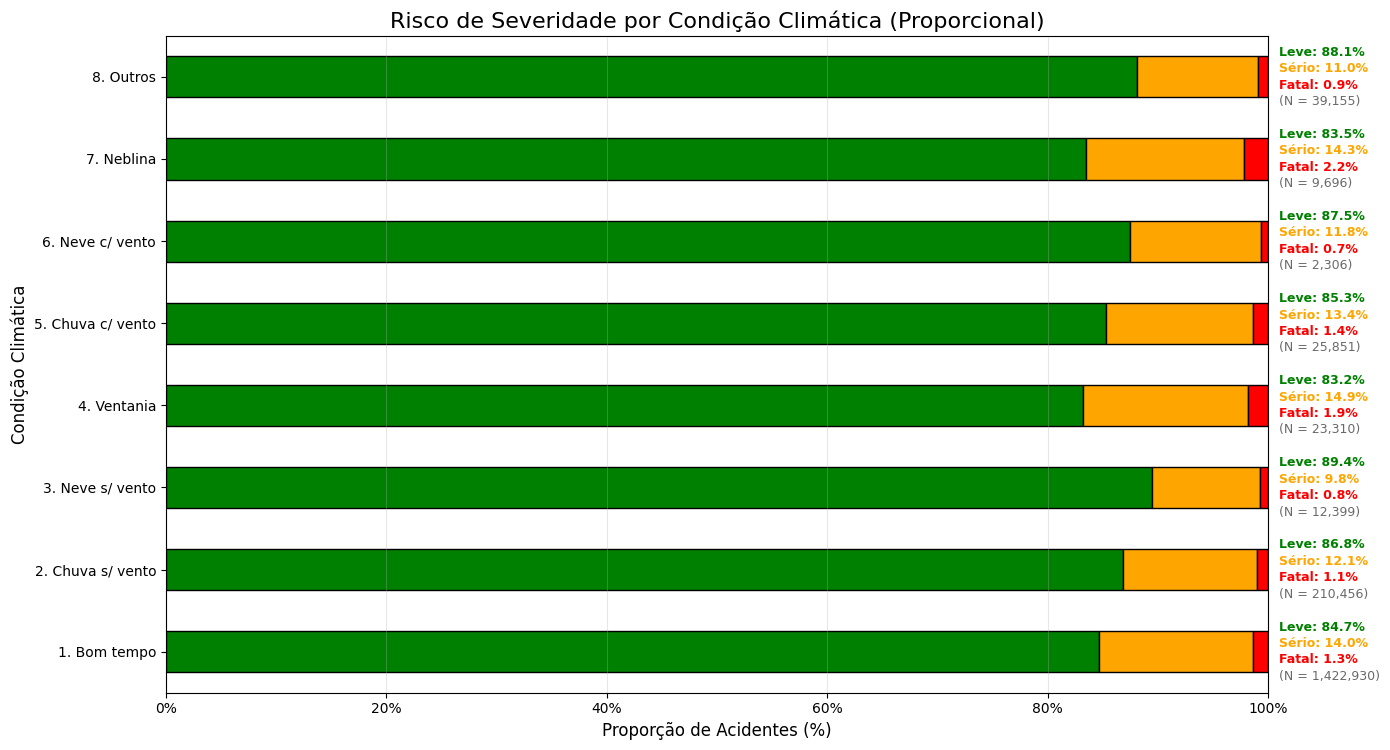

In [11]:
df_weather_agg = df_joined.filter(
    F.col("weather_conditions").isin([1, 2, 3, 4, 5, 6, 7, 8])
).select(
    "accident_index", "weather_conditions", "accident_severity"
).distinct().groupBy(
    "weather_conditions", "accident_severity"
).count()


pd_weather_data = df_weather_agg.toPandas()
weather_map = {
    1: '1. Bom tempo',
    2: '2. Chuva s/ vento',
    3: '3. Neve s/ vento',
    4: '4. Ventania',
    5: '5. Chuva c/ vento',
    6: '6. Neve c/ vento',
    7: '7. Neblina',
    8: '8. Outros'
}
severity_map = {1: 'Fatal', 2: 'Sério', 3: 'Leve'}

pd_weather_data['Weather_Label'] = pd_weather_data['weather_conditions'].map(weather_map)
pd_weather_data['Severity_Label'] = pd_weather_data['accident_severity'].map(severity_map)

pivot_weather = pd_weather_data.pivot(
    index='Weather_Label', 
    columns='Severity_Label', 
    values='count'
).fillna(0)

pivot_weather = pivot_weather[['Leve', 'Sério', 'Fatal']]

pivot_weather_totals = pivot_weather.sum(axis=1)
pivot_weather_normalized = pivot_weather.apply(lambda x: x / x.sum(), axis=1).fillna(0) * 100

fig, ax = plt.subplots(figsize=(14, 8)) 
pivot_weather_normalized.plot(
    kind='barh',
    stacked=True, 
    color={'Leve': 'green', 'Sério': 'orange', 'Fatal': 'red'}, 
    ax=ax,
    edgecolor="black",
    legend=False
)

for i, (index, row) in enumerate(pivot_weather_normalized.iterrows()):
    
    p_leve = row['Leve']
    p_serio = row['Sério']
    p_fatal = row['Fatal']
    total_accidents = pivot_weather_totals.iloc[i]

    x_pos = 101 
    base_y = i
    
    ax.text(x_pos, base_y + 0.3, f"Leve: {p_leve:.1f}%", 
            ha='left', va='center', fontsize=9, color='green', fontweight='bold')
    ax.text(x_pos, base_y + 0.1, f"Sério: {p_serio:.1f}%", 
            ha='left', va='center', fontsize=9, color='orange', fontweight='bold')
    ax.text(x_pos, base_y - 0.1, f"Fatal: {p_fatal:.1f}%", 
            ha='left', va='center', fontsize=9, color='red', fontweight='bold')
    ax.text(x_pos, base_y - 0.3, f"(N = {total_accidents:,.0f})", 
            ha='left', va='center', fontsize=9, color='dimgray')

ax.set_ylabel('Condição Climática', fontsize=12)
ax.set_xlabel('Proporção de Acidentes (%)', fontsize=12)
ax.set_title('Risco de Severidade por Condição Climática (Proporcional)', fontsize=16)
ax.grid(True, alpha=0.3, axis='x')

def percent_formatter(x, pos):
    return f'{x:.0f}%'
ax.xaxis.set_major_formatter(FuncFormatter(percent_formatter))

ax.set_xlim(0, 100)

plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()

### Severidade dos Acidentes por condição da pista

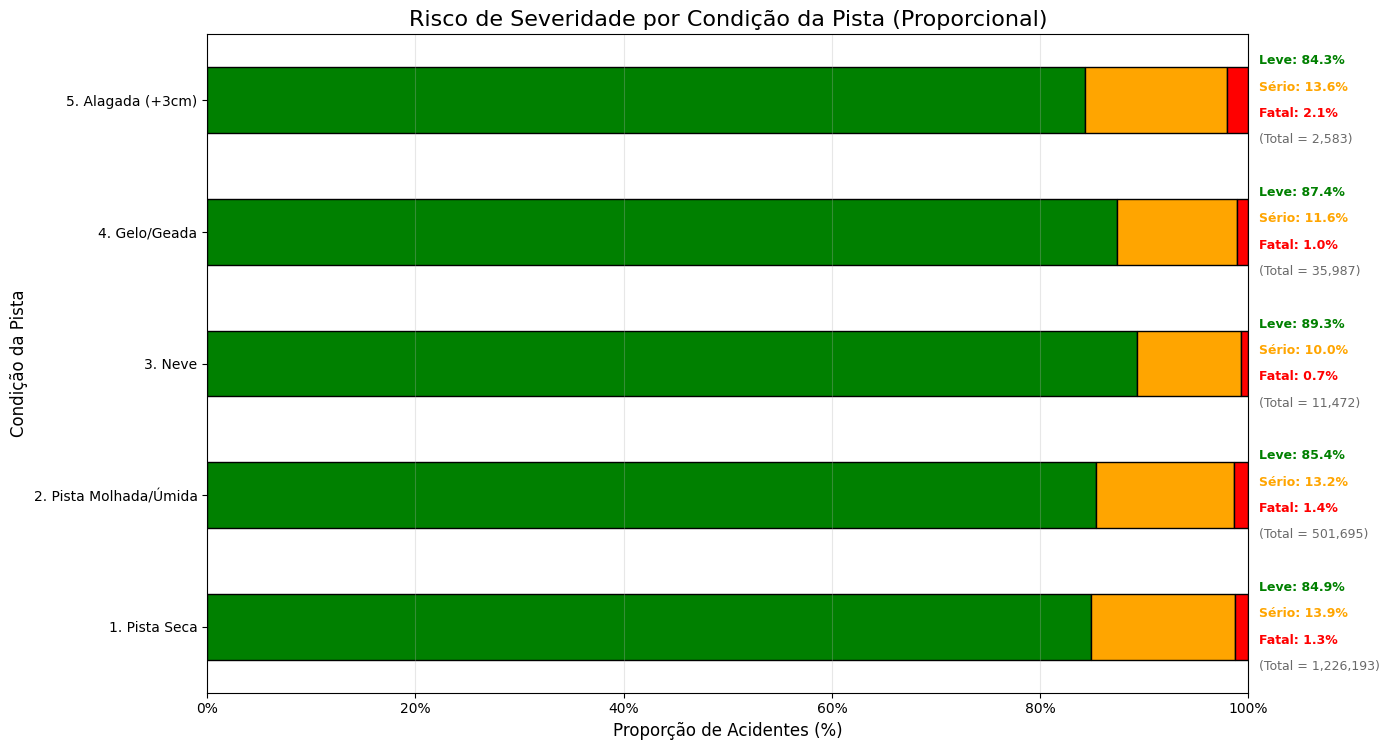

In [13]:
df_road_agg = df_joined.filter(
    F.col("road_surface_conditions").isin([1, 2, 3, 4, 5, 6, 7])
).select(
    "accident_index", "road_surface_conditions", "accident_severity"
).distinct().groupBy(
    "road_surface_conditions", "accident_severity"
).count()

pd_road_data = df_road_agg.toPandas()

road_map = {
    1: '1. Pista Seca', 2: '2. Pista Molhada/Úmida', 3: '3. Neve',
    4: '4. Gelo/Geada', 5: '5. Alagada (+3cm)', 6: '6. Óleo/Diesel', 7: '7. Lama'
}
severity_map = {1: 'Fatal', 2: 'Sério', 3: 'Leve'}
pd_road_data['Road_Label'] = pd_road_data['road_surface_conditions'].map(road_map)
pd_road_data['Severity_Label'] = pd_road_data['accident_severity'].map(severity_map)
pivot_road = pd_road_data.pivot(
    index='Road_Label', columns='Severity_Label', values='count'
).fillna(0)
pivot_road = pivot_road[['Leve', 'Sério', 'Fatal']]

pivot_road_totals = pivot_road.sum(axis=1) 
pivot_road_normalized = pivot_road.apply(lambda x: x / x.sum(), axis=1).fillna(0) * 100

fig, ax = plt.subplots(figsize=(14, 8)) 
pivot_road_normalized.plot(
    kind='barh',
    stacked=True, 
    color={'Leve': 'green', 'Sério': 'orange', 'Fatal': 'red'}, 
    ax=ax,
    edgecolor="black",
    legend=False
)

for i, (index, row) in enumerate(pivot_road_normalized.iterrows()):
    
    p_leve = row['Leve']
    p_serio = row['Sério']
    p_fatal = row['Fatal']
    total_accidents = pivot_road_totals.iloc[i]

    x_pos = 101 
    base_y = i
    
    
    ax.text(x_pos, base_y + 0.3, f"Leve: {p_leve:.1f}%", 
            ha='left', va='center', fontsize=9, color='green', fontweight='bold')
    
    ax.text(x_pos, base_y + 0.1, f"Sério: {p_serio:.1f}%", 
            ha='left', va='center', fontsize=9, color='orange', fontweight='bold')
    
    ax.text(x_pos, base_y - 0.1, f"Fatal: {p_fatal:.1f}%", 
            ha='left', va='center', fontsize=9, color='red', fontweight='bold')
    
    ax.text(x_pos, base_y - 0.3, f"(Total = {total_accidents:,.0f})", 
            ha='left', va='center', fontsize=9, color='dimgray')


ax.set_ylabel('Condição da Pista', fontsize=12)
ax.set_xlabel('Proporção de Acidentes (%)', fontsize=12)
ax.set_title('Risco de Severidade por Condição da Pista (Proporcional)', fontsize=16)
ax.grid(True, alpha=0.3, axis='x')

def percent_formatter(x, pos):
    return f'{x:.0f}%'
ax.xaxis.set_major_formatter(FuncFormatter(percent_formatter))

ax.set_xlim(0, 100)

plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()

### Urbano X Rural Severidade

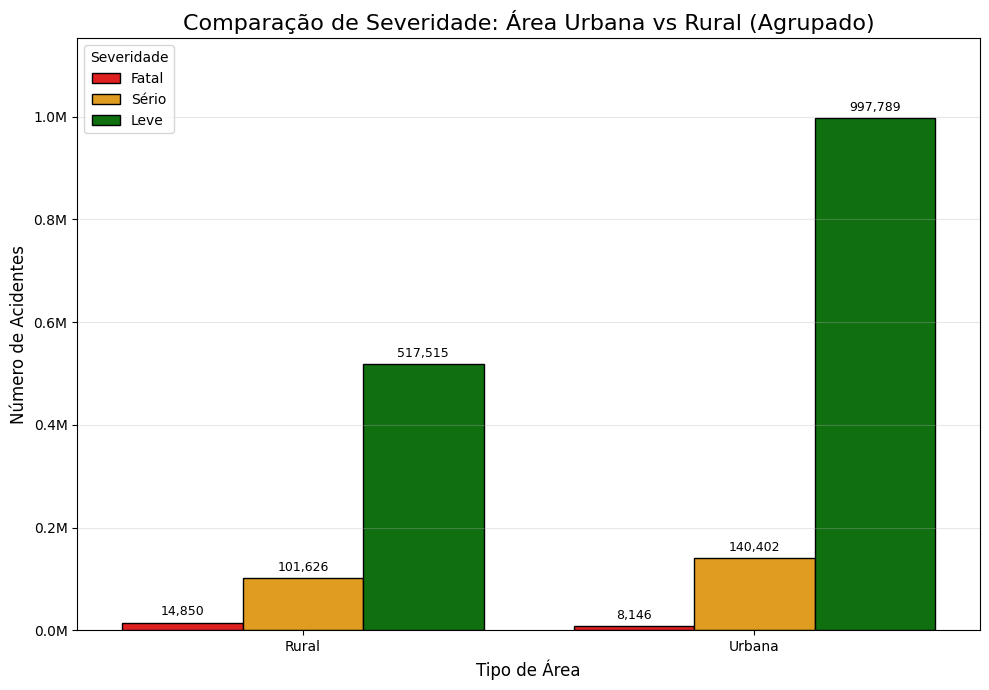

In [14]:
urban_rural_data_spark = df_joined.select(
    "accident_index", "urban_or_rural_area", "accident_severity"
).distinct().groupBy(
    "urban_or_rural_area", "accident_severity"
).count()

urban_rural_data = urban_rural_data_spark.toPandas()

urban_rural_data = urban_rural_data[urban_rural_data['urban_or_rural_area'].isin([1, 2])]

area_map = {1: 'Urbana', 2: 'Rural'}
severity_map = {1: 'Fatal', 2: 'Sério', 3: 'Leve'}
urban_rural_data['area_label'] = urban_rural_data['urban_or_rural_area'].map(area_map)
urban_rural_data['severity_label'] = urban_rural_data['accident_severity'].map(severity_map)


plt.figure(figsize=(10, 7))

palette_colors = {'Fatal': 'red', 'Sério': 'orange', 'Leve': 'green'}

ax = sns.barplot(
    data=urban_rural_data, 
    x='area_label', 
    y='count', 
    hue='severity_label', 
    palette=palette_colors,
    hue_order=['Fatal', 'Sério', 'Leve'],
    edgecolor='black'
)

for container in ax.containers:
    ax.bar_label(
        container, 
        fmt='{:,.0f}',
        fontsize=9,     
        padding=3       
    )


def millions_formatter(y, pos):
    return f'{y/1e6:.1f}M'
ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))

ax.set_ylim(top=ax.get_ylim()[1] * 1.1)


plt.xlabel('Tipo de Área', fontsize=12)
plt.ylabel('Número de Acidentes', fontsize=12)
plt.title('Comparação de Severidade: Área Urbana vs Rural (Agrupado)', fontsize=16)
plt.legend(title='Severidade')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()

plt.show()

### Tendencia de acidentes por idade do veiculo

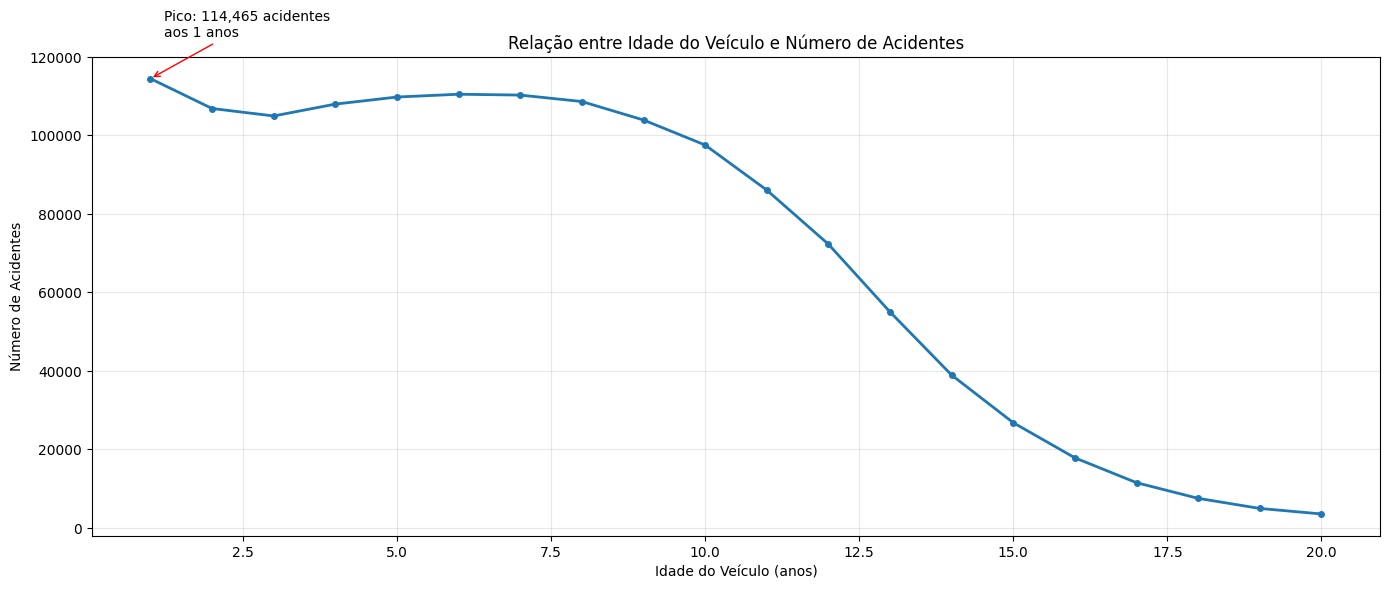

In [15]:
exact_age_data = df_joined.select(
    F.col("age_of_vehicle").cast("int").alias("vehicle_age"),
    F.col("accident_index")
).filter(F.col("age_of_vehicle").isNotNull() & 
         (F.col("age_of_vehicle") >= 0) & 
         (F.col("age_of_vehicle") <= 20)).distinct()

exact_age_count = exact_age_data.groupBy("vehicle_age").count().orderBy("vehicle_age").toPandas()

plt.figure(figsize=(14, 6))
plt.plot(exact_age_count['vehicle_age'], exact_age_count['count'], marker='o', linewidth=2, markersize=4)
plt.xlabel('Idade do Veículo (anos)')
plt.ylabel('Número de Acidentes')
plt.title('Relação entre Idade do Veículo e Número de Acidentes')
plt.grid(True, alpha=0.3)

max_age = exact_age_count.loc[exact_age_count['count'].idxmax()]
plt.annotate(f'Pico: {max_age["count"]:,} acidentes\naos {max_age["vehicle_age"]} anos', 
             xy=(max_age['vehicle_age'], max_age['count']),
             xytext=(10, 30), textcoords='offset points',
             arrowprops=dict(arrowstyle='->', color='red'))

plt.tight_layout()
plt.show()

### Piramide Etaria Severidade do Acidente

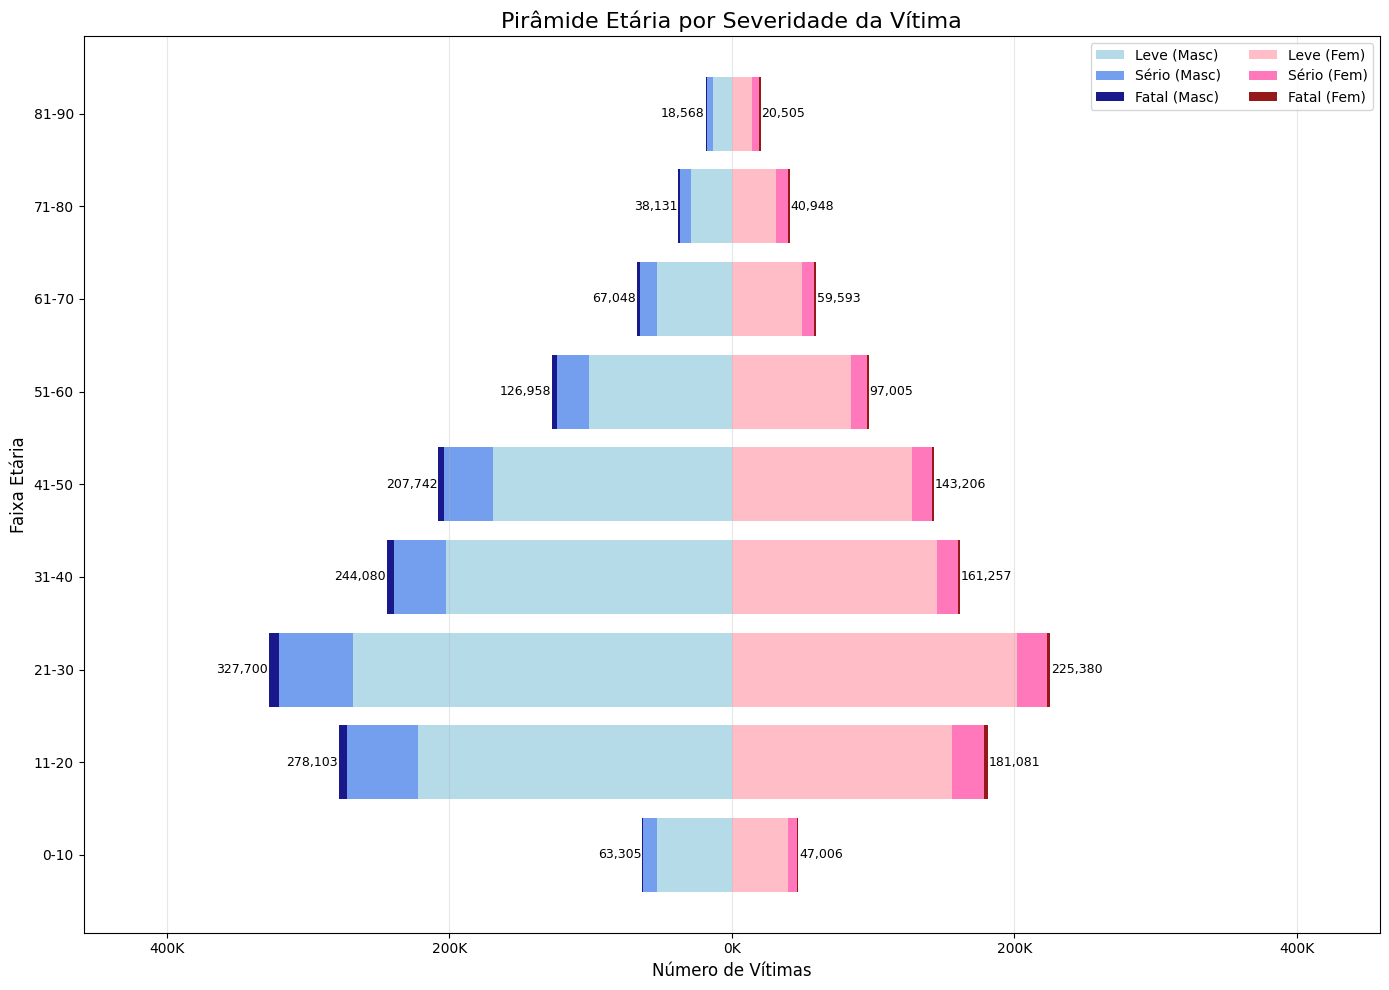

In [16]:
pyramid_data_sev = df_joined.select(
    F.col("age_of_casualty").cast("int").alias("age"),
    F.col("sex_of_casualty").alias("gender"),
    F.col("accident_severity")
).filter(
    (F.col("age").isNotNull()) & 
    (F.col("age") > 0) & 
    (F.col("age") <= 90) &
    (F.col("gender").isin([1, 2])) &
    (F.col("accident_severity").isin([1, 2, 3]))
)

age_bins = [
    (0, 10, "0-10"), (11, 20, "11-20"), (21, 30, "21-30"),
    (31, 40, "31-40"), (41, 50, "41-50"), (51, 60, "51-60"),
    (61, 70, "61-70"), (71, 80, "71-80"), (81, 90, "81-90")
]
condition_expr = F.when((F.col("age") >= 0) & (F.col("age") <= 10), "0-10")
for min_age, max_age, label in age_bins[1:]:
    condition_expr = condition_expr.when((F.col("age") >= min_age) & (F.col("age") <= max_age), label)
pyramid_data_sev = pyramid_data_sev.withColumn("age_group", condition_expr)


pyramid_counts_sev = pyramid_data_sev.groupBy(
    "age_group", "gender", "accident_severity"
).count().orderBy("age_group").collect()

age_labels = [label for _, _, label in age_bins]
y_pos = np.arange(len(age_labels))

plot_data_sev = {
    age_label: {
        1: {1: 0, 2: 0, 3: 0},
        2: {1: 0, 2: 0, 3: 0}
    } for age_label in age_labels
}

for row in pyramid_counts_sev:
    if row['age_group'] in plot_data_sev:
        plot_data_sev[row['age_group']][row['gender']][row['accident_severity']] = row['count']

male_leve_counts = [plot_data_sev[age][1][3] for age in age_labels]
male_serio_counts = [plot_data_sev[age][1][2] for age in age_labels]
male_fatal_counts = [plot_data_sev[age][1][1] for age in age_labels]

female_leve_counts = [plot_data_sev[age][2][3] for age in age_labels]
female_serio_counts = [plot_data_sev[age][2][2] for age in age_labels]
female_fatal_counts = [plot_data_sev[age][2][1] for age in age_labels]


fig, ax = plt.subplots(figsize=(14, 10))

male_leve = np.array(male_leve_counts)
male_serio = np.array(male_serio_counts)
male_fatal = np.array(male_fatal_counts)
male_bottom_serio = male_leve 
male_bottom_fatal = male_leve + male_serio 

ax.barh(y_pos, -male_leve, color='lightblue', label='Leve (Masc)', alpha=0.9)
ax.barh(y_pos, -male_serio, left=-male_bottom_serio, color='cornflowerblue', label='Sério (Masc)', alpha=0.9)
ax.barh(y_pos, -male_fatal, left=-male_bottom_fatal, color='navy', label='Fatal (Masc)', alpha=0.9)

female_leve = np.array(female_leve_counts)
female_serio = np.array(female_serio_counts)
female_fatal = np.array(female_fatal_counts)
female_bottom_serio = female_leve
female_bottom_fatal = female_leve + female_serio

ax.barh(y_pos, female_leve, color='lightpink', label='Leve (Fem)', alpha=0.9)
ax.barh(y_pos, female_serio, left=female_bottom_serio, color='hotpink', label='Sério (Fem)', alpha=0.9)
ax.barh(y_pos, female_fatal, left=female_bottom_fatal, color='darkred', label='Fatal (Fem)', alpha=0.9)

ax.set_yticks(y_pos)
ax.set_yticklabels(age_labels)
ax.set_xlabel('Número de Vítimas', fontsize=12)
ax.set_ylabel('Faixa Etária', fontsize=12)
ax.set_title('Pirâmide Etária por Severidade da Vítima', fontsize=16)

male_totals = male_leve + male_serio + male_fatal
female_totals = female_leve + female_serio + female_fatal

for i, (male, female) in enumerate(zip(male_totals, female_totals)):
    if male > 0:
        ax.text(-male - 500, i, f'{male:,.0f}', ha='right', va='center', fontsize=9, color='black')
    if female > 0:
        ax.text(female + 500, i, f'{female:,.0f}', ha='left', va='center', fontsize=9, color='black')

formatter = FuncFormatter(lambda x, pos: f'{abs(x)/1e3:.0f}K')
ax.xaxis.set_major_formatter(formatter)

max_val = max(male_totals.max(), female_totals.max())
ax.set_xlim(-max_val * 1.4, max_val * 1.4)

ax.legend(ncol=2)
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

### Piramide Etaria Tipo de Vítima do Acidente

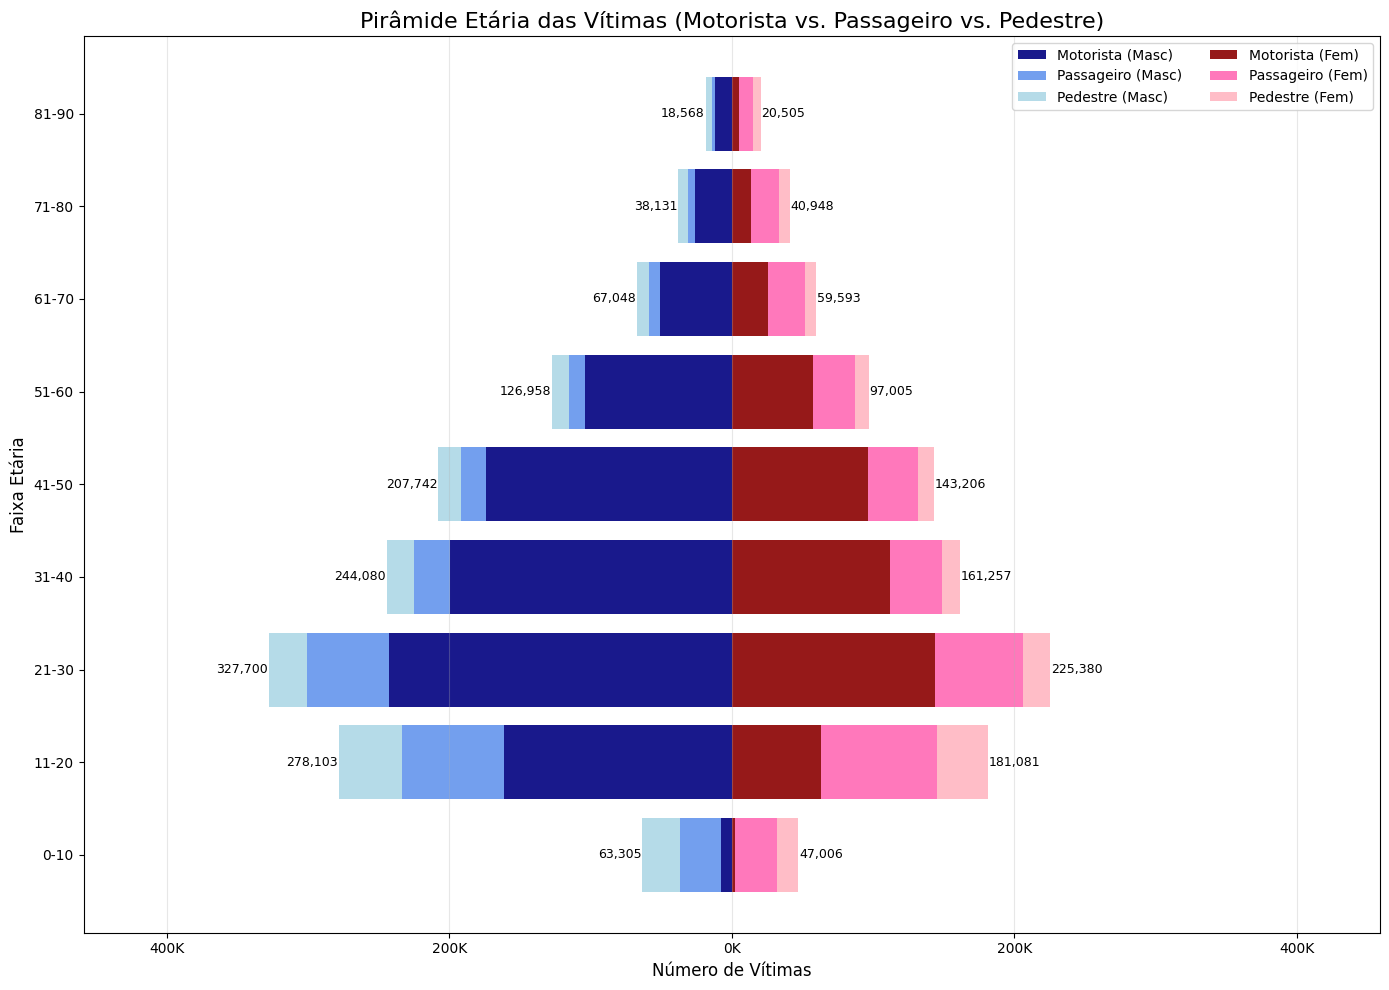

In [17]:
pyramid_data_stacked = df_joined.select(
    F.col("age_of_casualty").cast("int").alias("age"),
    F.col("sex_of_casualty").alias("gender"),
    F.col("Casualty_Class")
).filter(
    (F.col("age").isNotNull()) & 
    (F.col("age") > 0) & 
    (F.col("age") <= 90) &
    (F.col("gender").isin([1, 2])) &
    (F.col("Casualty_Class").isin([1, 2, 3]))
)

age_bins = [
    (0, 10, "0-10"), (11, 20, "11-20"), (21, 30, "21-30"),
    (31, 40, "31-40"), (41, 50, "41-50"), (51, 60, "51-60"),
    (61, 70, "61-70"), (71, 80, "71-80"), (81, 90, "81-90")
]
condition_expr = F.when((F.col("age") >= 0) & (F.col("age") <= 10), "0-10")
for min_age, max_age, label in age_bins[1:]:
    condition_expr = condition_expr.when((F.col("age") >= min_age) & (F.col("age") <= max_age), label)
pyramid_data_stacked = pyramid_data_stacked.withColumn("age_group", condition_expr)


pyramid_counts_stacked = pyramid_data_stacked.groupBy(
    "age_group", "gender", "Casualty_Class"
).count().orderBy("age_group").collect()

age_labels = [label for _, _, label in age_bins]
y_pos = np.arange(len(age_labels))

plot_data = {
    age_label: {
        1: {1: 0, 2: 0, 3: 0},
        2: {1: 0, 2: 0, 3: 0}
    } for age_label in age_labels
}

for row in pyramid_counts_stacked:
    if row['age_group'] in plot_data:
        plot_data[row['age_group']][row['gender']][row['Casualty_Class']] = row['count']

stack_order = [1, 2, 3] 

male_driver_counts = [plot_data[age][1][1] for age in age_labels]
male_pass_counts = [plot_data[age][1][2] for age in age_labels]
male_ped_counts = [plot_data[age][1][3] for age in age_labels]

female_driver_counts = [plot_data[age][2][1] for age in age_labels]
female_pass_counts = [plot_data[age][2][2] for age in age_labels]
female_ped_counts = [plot_data[age][2][3] for age in age_labels]


fig, ax = plt.subplots(figsize=(14, 10))

male_bottom_driver = np.array(male_driver_counts)
male_bottom_pass = male_bottom_driver + np.array(male_pass_counts)

ax.barh(y_pos, -np.array(male_driver_counts), color='navy', label='Motorista (Masc)', alpha=0.9)
ax.barh(y_pos, -np.array(male_pass_counts), left=-male_bottom_driver, color='cornflowerblue', label='Passageiro (Masc)', alpha=0.9)
ax.barh(y_pos, -np.array(male_ped_counts), left=-male_bottom_pass, color='lightblue', label='Pedestre (Masc)', alpha=0.9)

female_bottom_driver = np.array(female_driver_counts)
female_bottom_pass = female_bottom_driver + np.array(female_pass_counts)

ax.barh(y_pos, female_driver_counts, color='darkred', label='Motorista (Fem)', alpha=0.9)
ax.barh(y_pos, female_pass_counts, left=female_bottom_driver, color='hotpink', label='Passageiro (Fem)', alpha=0.9)
ax.barh(y_pos, female_ped_counts, left=female_bottom_pass, color='lightpink', label='Pedestre (Fem)', alpha=0.9)

ax.set_yticks(y_pos)
ax.set_yticklabels(age_labels)
ax.set_xlabel('Número de Vítimas', fontsize=12)
ax.set_ylabel('Faixa Etária', fontsize=12)
ax.set_title('Pirâmide Etária das Vítimas (Motorista vs. Passageiro vs. Pedestre)', fontsize=16)

male_totals = male_bottom_pass + np.array(male_ped_counts)
female_totals = female_bottom_pass + np.array(female_ped_counts)

for i, (male, female) in enumerate(zip(male_totals, female_totals)):
    if male > 0:
        ax.text(-male - 500, i, f'{male:,.0f}', ha='right', va='center', fontsize=9, color='black')
    if female > 0:
        ax.text(female + 500, i, f'{female:,.0f}', ha='left', va='center', fontsize=9, color='black')

formatter = FuncFormatter(lambda x, pos: f'{abs(x)/1e3:.0f}K')
ax.xaxis.set_major_formatter(formatter)

max_val = max(male_totals.max(), female_totals.max())
ax.set_xlim(-max_val * 1.4, max_val * 1.4)

ax.legend(ncol=2)
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

### Tipos de Veiculos dirigidos por menores de idade

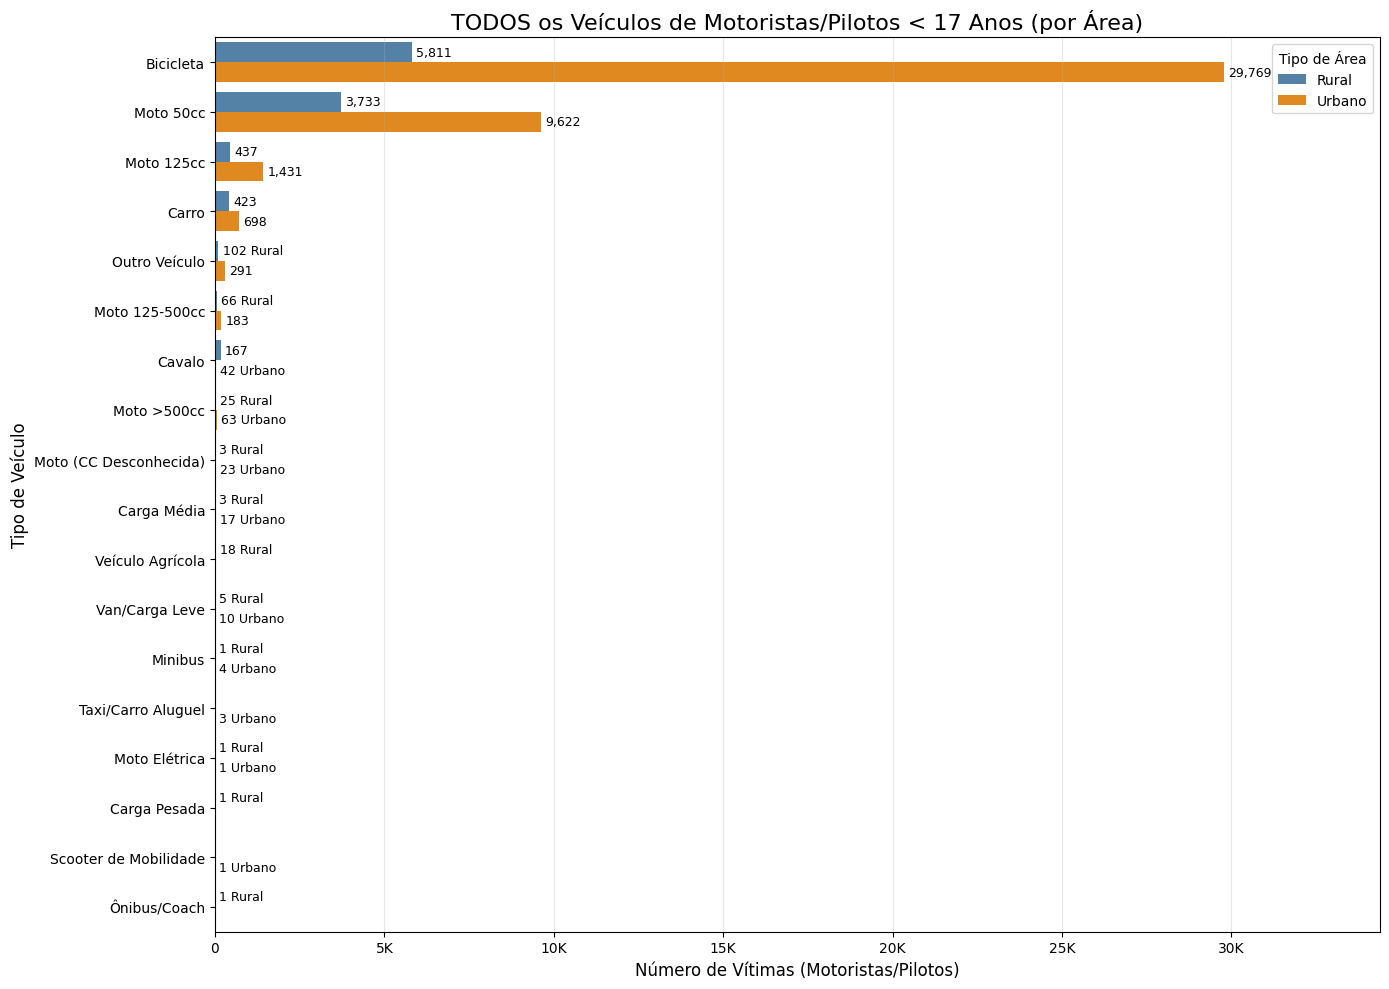

In [18]:
df_underage_drivers_area = df_joined.filter(
    (F.col("Casualty_Class") == 1) &
    (F.col("age_of_casualty") < 17) &
    (F.col("age_of_casualty") > 0) &
    (F.col("Urban_or_Rural_Area").isin([1, 2])) 
)
df_agg_area = df_underage_drivers_area.groupBy(
    "Vehicle_Type", "Urban_or_Rural_Area"
).count()
pd_plot_data_area = df_agg_area.toPandas()
area_map = {1: 'Urbano', 2: 'Rural'}
vehicle_type_map = {
    1: 'Bicicleta', 2: 'Moto 50cc', 3: 'Moto 125cc', 4: 'Moto 125-500cc',
    5: 'Moto >500cc', 8: 'Taxi/Carro Aluguel', 9: 'Carro',
    10: 'Minibus', 11: 'Ônibus/Coach', 16: 'Cavalo', 17: 'Veículo Agrícola',
    18: 'Bonde (Tram)', 19: 'Van/Carga Leve', 20: 'Carga Média', 21: 'Carga Pesada',
    22: 'Scooter de Mobilidade', 23: 'Moto Elétrica', 90: 'Outro Veículo',
    97: 'Moto (CC Desconhecida)', 98: 'Carga (Peso Desconhec.)', -1: 'Desconhecido'
}

pd_plot_data_area['Area_Label'] = pd_plot_data_area['Urban_or_Rural_Area'].map(area_map)
pd_plot_data_area['Vehicle_Label'] = pd_plot_data_area['Vehicle_Type'].map(vehicle_type_map)
pd_plot_data_area = pd_plot_data_area.dropna(subset=['Vehicle_Label', 'Area_Label'])

order_index = pd_plot_data_area.groupby("Vehicle_Label")['count'].sum().sort_values(ascending=False).index
pd_plot_data_all = pd_plot_data_area 

num_veiculos = len(order_index)
plt.figure(figsize=(14, num_veiculos * 0.5 + 1)) 

ax = sns.barplot(
    data=pd_plot_data_all,
    y="Vehicle_Label",  
    x="count",          
    hue="Area_Label",   
    palette={"Urbano": "darkorange", "Rural": "steelblue"},
    order=order_index   
)

ax.set_title('TODOS os Veículos de Motoristas/Pilotos < 17 Anos (por Área)', fontsize=16)
ax.set_ylabel('Tipo de Veículo', fontsize=12)
ax.set_xlabel('Número de Vítimas (Motoristas/Pilotos)', fontsize=12)
ax.legend(title="Tipo de Área")



legend_labels = [t.get_text() for t in ax.get_legend().get_texts()]

for i, container in enumerate(ax.containers):
    
    container_label = legend_labels[i]

    custom_labels = []
    for bar in container:
        count = bar.get_width()
        if 0 < count < 150:
            label_text = f"{count:,.0f} {container_label}"
        else:
            label_text = f"{count:,.0f}"
        
        custom_labels.append(label_text)
        
    ax.bar_label(container, labels=custom_labels, padding=3, fontsize=9)

formatter = FuncFormatter(lambda x, pos: f'{x/1e3:.0f}K' if x > 0 else 0)
ax.xaxis.set_major_formatter(formatter)
ax.set_xlim(right=ax.get_xlim()[1] * 1.1) 

plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

### Mapa de Calor pela Quantidade de Acidentes

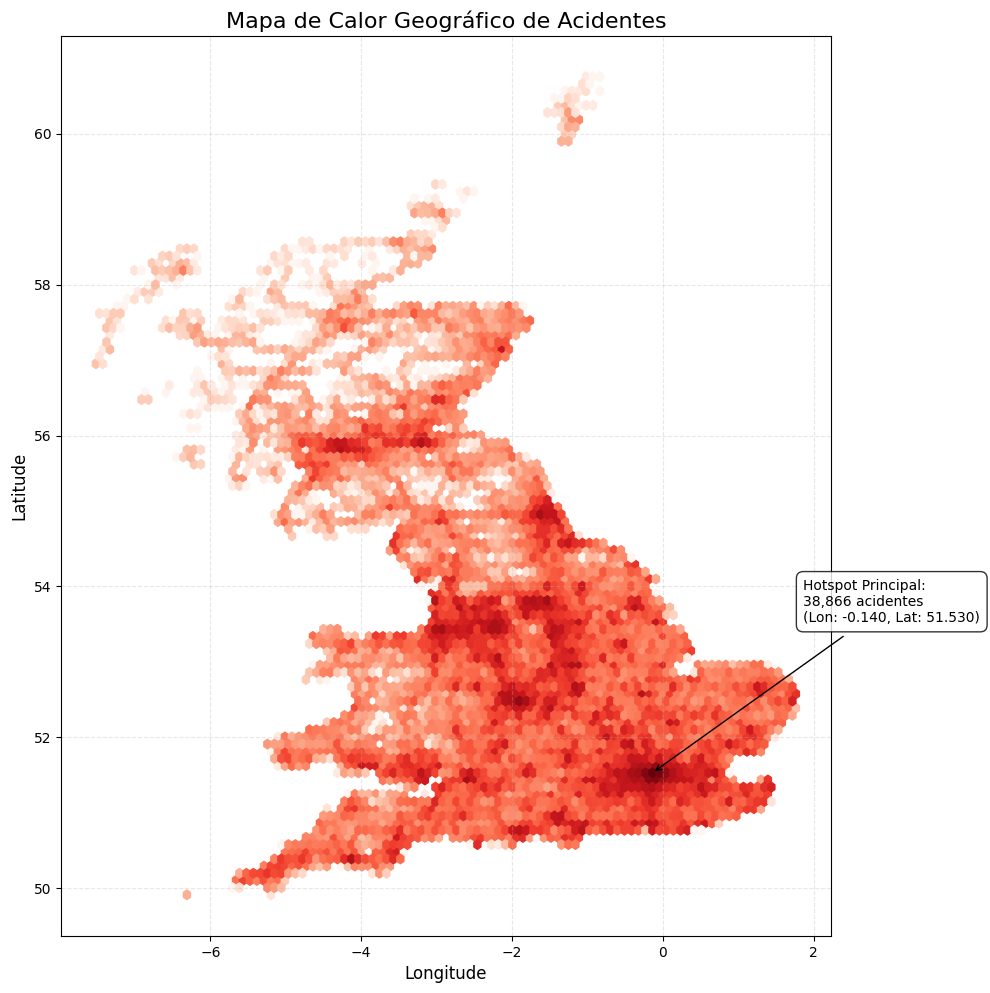

In [19]:
df_geo_100pct = df_joined.select(
    "accident_index",
    "longitude", 
    "latitude"
).distinct().filter(
    F.col("longitude").isNotNull() & 
    F.col("latitude").isNotNull() &
    (F.col("longitude") != 0) & 
    (F.col("latitude") != 0)
)

pd_geo_100pct = df_geo_100pct.toPandas()

plt.figure(figsize=(10, 12))

hb = plt.hexbin(
    x=pd_geo_100pct['longitude'],
    y=pd_geo_100pct['latitude'],
    gridsize=100,      
    cmap='Reds',       
    bins='log',
    mincnt=1
)

plt.title('Mapa de Calor Geográfico de Acidentes', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)

counts = hb.get_array()
max_count = np.max(counts)
max_index = np.argmax(counts)

offsets = hb.get_offsets()
hotspot_coords = offsets[max_index]
hotspot_lon = hotspot_coords[0]
hotspot_lat = hotspot_coords[1]

hotspot_text = (
    f"Hotspot Principal:\n"
    f"{max_count:,.0f} acidentes\n"
    f"(Lon: {hotspot_lon:.3f}, Lat: {hotspot_lat:.3f})"
)

plt.annotate(
    hotspot_text,
    xy=(hotspot_lon, hotspot_lat), 
    xytext=(hotspot_lon + 2, hotspot_lat + 2), 
    arrowprops=dict(arrowstyle='->', color='black', shrinkA=5),
    bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="black", lw=1, alpha=0.8) 
)

plt.gca().set_aspect('equal', adjustable='box') 
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

### Severidade de Acidentes com volantes a Esquerda e a Direita

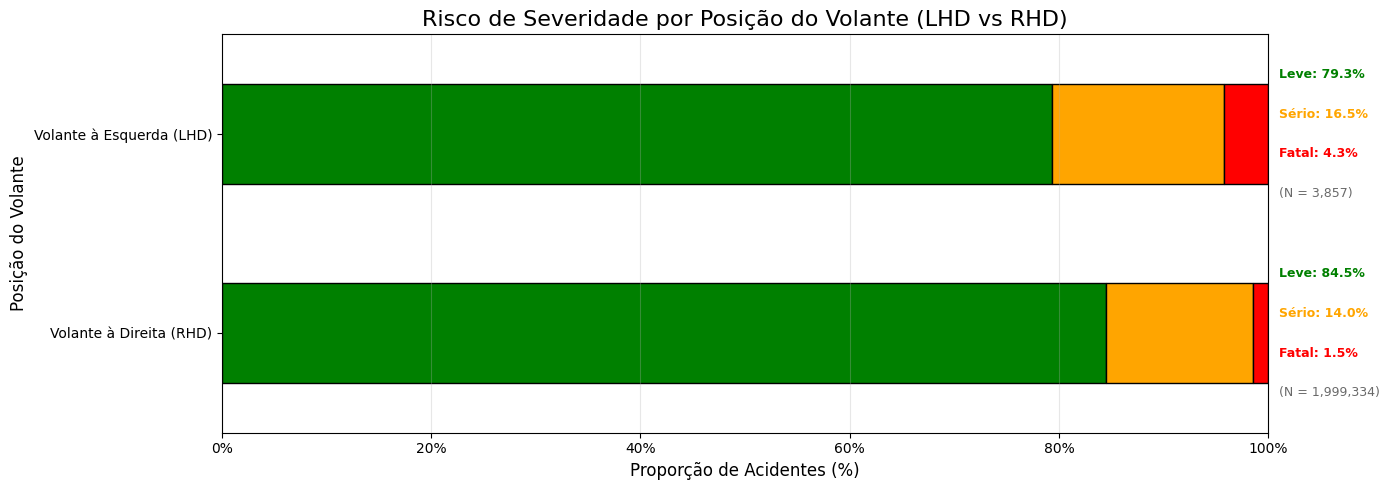

In [22]:
df_lhd_agg = df_joined.filter(
    F.col("was_vehicle_left_hand_drive").isin([1, 2])
).select(
    "accident_index", "vehicle_reference", "was_vehicle_left_hand_drive", "accident_severity"
).distinct().groupBy(
    "was_vehicle_left_hand_drive", "accident_severity"
).count()

pd_lhd_data = df_lhd_agg.toPandas()

lhd_map = {1: 'Volante à Direita (RHD)', 2: 'Volante à Esquerda (LHD)'}
severity_map = {1: 'Fatal', 2: 'Sério', 3: 'Leve'}

pd_lhd_data['LHD_Label'] = pd_lhd_data['was_vehicle_left_hand_drive'].map(lhd_map)
pd_lhd_data['Severity_Label'] = pd_lhd_data['accident_severity'].map(severity_map)

pivot_lhd = pd_lhd_data.pivot(
    index='LHD_Label', columns='Severity_Label', values='count'
).fillna(0)
pivot_lhd = pivot_lhd[['Leve', 'Sério', 'Fatal']]

pivot_lhd_totals = pivot_lhd.sum(axis=1) 
pivot_lhd_normalized = pivot_lhd.apply(lambda x: x / x.sum(), axis=1).fillna(0) * 100

fig, ax = plt.subplots(figsize=(14, 5))
pivot_lhd_normalized.plot(
    kind='barh', stacked=True, 
    color={'Leve': 'green', 'Sério': 'orange', 'Fatal': 'red'}, 
    ax=ax, edgecolor="black", legend=False
)

for i, (index, row) in enumerate(pivot_lhd_normalized.iterrows()):
    p_leve = row['Leve']
    p_serio = row['Sério']
    p_fatal = row['Fatal']
    total_accidents = pivot_lhd_totals.loc[index]
    x_pos = 101; base_y = i
    
    ax.text(x_pos, base_y + 0.3, f"Leve: {p_leve:.1f}%", 
            ha='left', va='center', fontsize=9, color='green', fontweight='bold')
    ax.text(x_pos, base_y + 0.1, f"Sério: {p_serio:.1f}%", 
            ha='left', va='center', fontsize=9, color='orange', fontweight='bold')
    ax.text(x_pos, base_y - 0.1, f"Fatal: {p_fatal:.1f}%", 
            ha='left', va='center', fontsize=9, color='red', fontweight='bold')
    ax.text(x_pos, base_y - 0.3, f"(N = {total_accidents:,.0f})", 
            ha='left', va='center', fontsize=9, color='dimgray')

ax.set_ylabel('Posição do Volante', fontsize=12)
ax.set_xlabel('Proporção de Acidentes (%)', fontsize=12)
ax.set_title('Risco de Severidade por Posição do Volante (LHD vs RHD)', fontsize=16)
ax.grid(True, alpha=0.3, axis='x')

ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x:.0f}%'))

ax.set_xlim(0, 100)

plt.tight_layout()
plt.show()

### Análise de Vulnerabilidade: Fatalidades por Grupo de Veículo

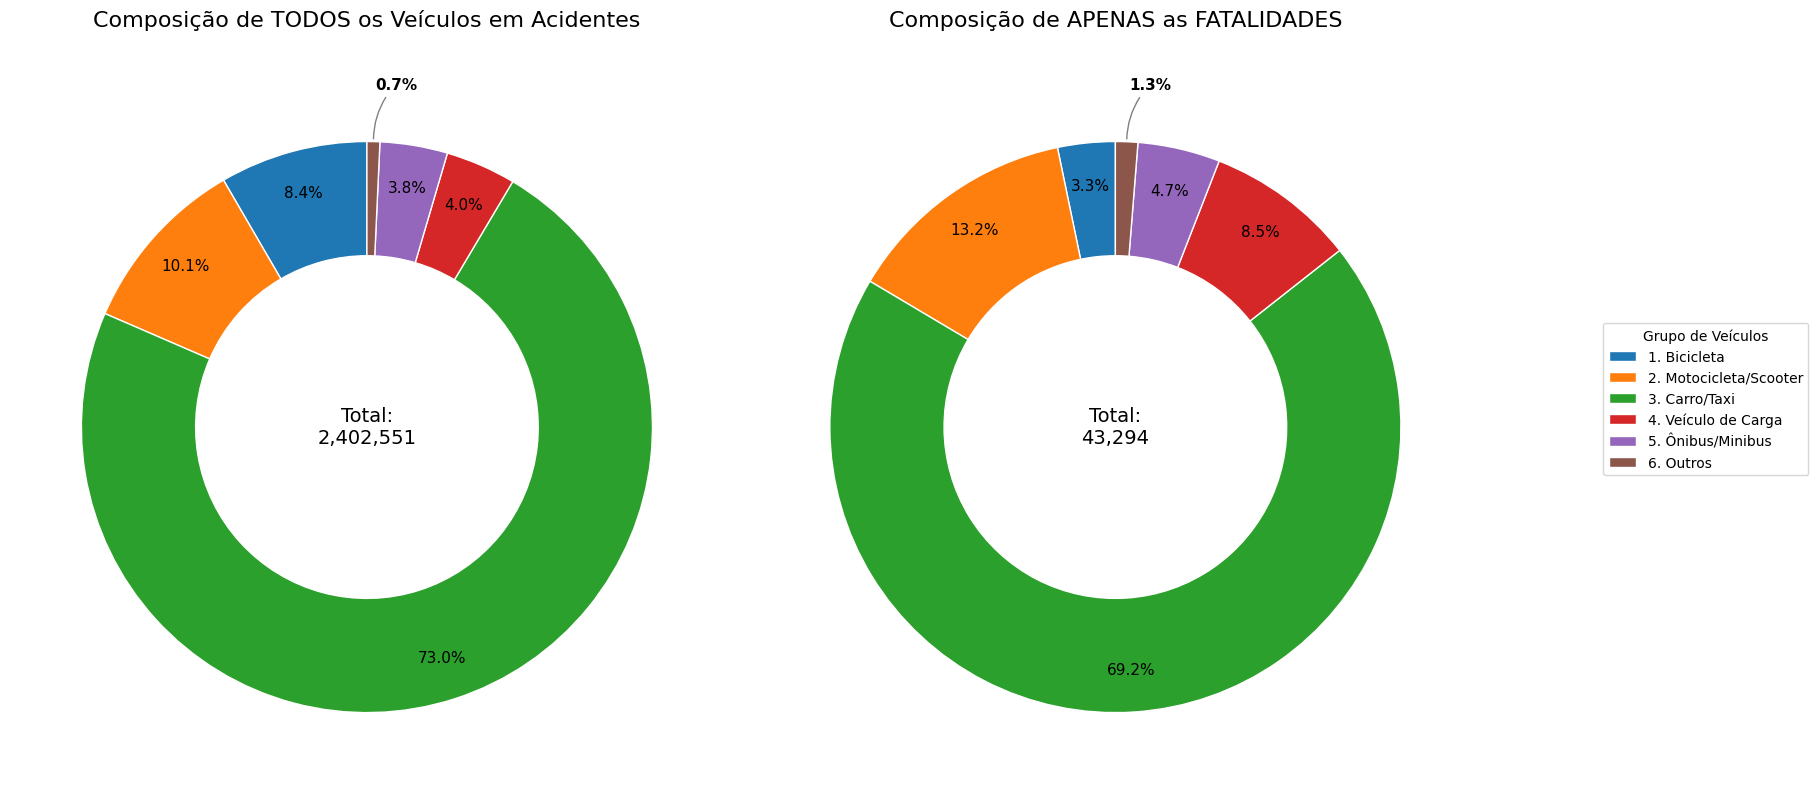

In [25]:
vehicle_group_expr = F.when(F.col("Vehicle_Type") == 1, "1. Bicicleta") \
    .when(F.col("Vehicle_Type").isin([2, 3, 4, 5, 23, 97, 22]), "2. Motocicleta/Scooter") \
    .when(F.col("Vehicle_Type").isin([8, 9]), "3. Carro/Taxi") \
    .when(F.col("Vehicle_Type").isin([19, 20, 21, 98]), "4. Veículo de Carga") \
    .when(F.col("Vehicle_Type").isin([10, 11]), "5. Ônibus/Minibus") \
    .otherwise("6. Outros") 

df_with_vehicle_groups = df_joined.withColumn("Vehicle_Group", vehicle_group_expr)

df_all_accidents = df_with_vehicle_groups.groupBy("Vehicle_Group") \
    .count() \
    .withColumnRenamed("count", "total_count")

df_fatal_accidents = df_with_vehicle_groups.filter(F.col("accident_severity") == 1) \
    .groupBy("Vehicle_Group") \
    .count() \
    .withColumnRenamed("count", "fatal_count")

df_combined = df_all_accidents.join(df_fatal_accidents, "Vehicle_Group", "left").fillna(0)
pd_plot_data = df_combined.toPandas().set_index("Vehicle_Group").sort_index()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8)) 
colors = plt.get_cmap('tab10')(range(len(pd_plot_data)))

def plot_donut_with_external_labels(ax, data, title, total_value, colors, threshold=1.5):
    wedges, texts, autotexts = ax.pie(
        data, 
        autopct='%1.1f%%', 
        startangle=90, 
        pctdistance=0.85, 
        colors=colors, 
        wedgeprops=dict(width=0.4, edgecolor='w'),
        textprops=dict(color="black", fontsize=9) 
    )
    ax.set_title(title, fontsize=16, y=1.05)
    ax.text(0, 0, f"Total:\n{total_value:,.0f}", ha='center', va='center', fontsize=14)

    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "arc3,rad=.2"
        
        if data.iloc[i] / data.sum() * 100 < threshold:
            autotexts[i].set_visible(False) 
            ax.annotate(f"{data.iloc[i] / data.sum() * 100:.1f}%",
                        xy=(x, y), xytext=(1.2*x, 1.2*y), textcoords='data',
                        fontsize=11,fontweight='bold', color='black', ha=horizontalalignment, va='center',
                        bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.7),
                        arrowprops=dict(arrowstyle="-", connectionstyle=connectionstyle, color='gray')
                       )
        else:
            autotexts[i].set_fontsize(11)
    
    return wedges, texts, autotexts

wedges1, _, _ = plot_donut_with_external_labels(
    axes[0], 
    pd_plot_data['total_count'], 
    'Composição de TODOS os Veículos em Acidentes', 
    pd_plot_data['total_count'].sum(), 
    colors,
    threshold=1.5 
)

plot_donut_with_external_labels(
    axes[1], 
    pd_plot_data['fatal_count'], 
    'Composição de APENAS as FATALIDADES', 
    pd_plot_data['fatal_count'].sum(), 
    colors,
    threshold=1.5
)

labels = pd_plot_data.index.tolist()
fig.legend(wedges1, labels, title="Grupo de Veículos", loc="center left", bbox_to_anchor=(0.9, 0.5))

plt.tight_layout(rect=[0, 0, 0.85, 1]) 
plt.show()

### Situação dos Pedestres Vítimas de Acidentes

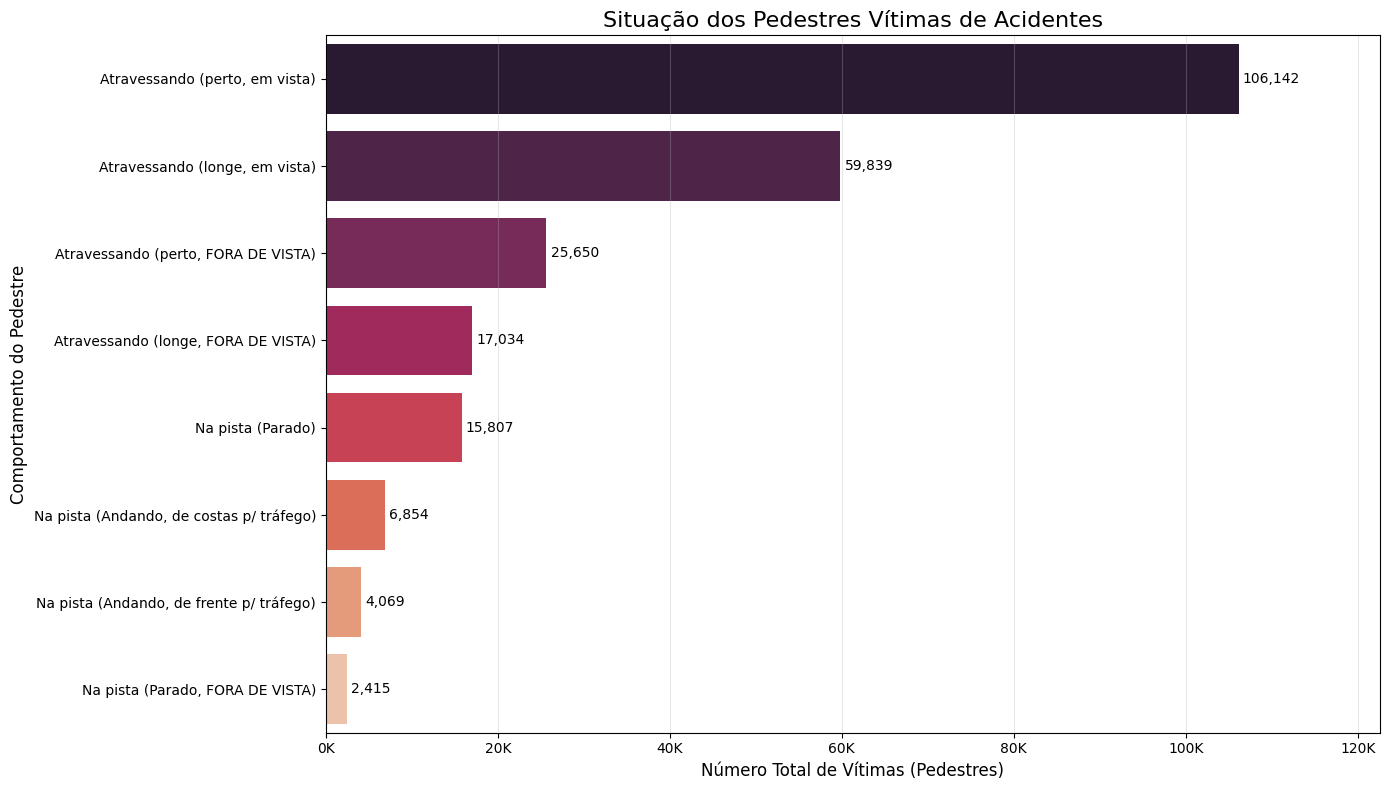

In [24]:
df_ped_agg = df_joined.filter(
    (F.col("Casualty_Class") == 3) &
    (F.col("pedestrian_movement").isin([1, 2, 3, 4, 5, 6, 7, 8]))
).groupBy(
    "pedestrian_movement"
).count()

pd_ped_data = df_ped_agg.toPandas()

ped_movement_map = {
    1: "Atravessando (perto, em vista)",
    2: "Atravessando (perto, FORA DE VISTA)",
    3: "Atravessando (longe, em vista)",
    4: "Atravessando (longe, FORA DE VISTA)",
    5: "Na pista (Parado)",
    6: "Na pista (Parado, FORA DE VISTA)",
    7: "Na pista (Andando, de frente p/ tráfego)",
    8: "Na pista (Andando, de costas p/ tráfego)"
}
pd_ped_data['Causa_Label'] = pd_ped_data['pedestrian_movement'].map(ped_movement_map)

pd_ped_data = pd_ped_data.sort_values(by='count', ascending=False)

plt.figure(figsize=(14, 8))
ax = sns.barplot(
    data=pd_ped_data,
    y='Causa_Label',
    x='count',
    palette="rocket",
    hue='Causa_Label',
    legend=False
)

ax.set_title('Situação dos Pedestres Vítimas de Acidentes', fontsize=16)
ax.set_ylabel('Comportamento do Pedestre', fontsize=12)
ax.set_xlabel('Número Total de Vítimas (Pedestres)', fontsize=12)

for container in ax.containers:
    ax.bar_label(container, fmt='{:,.0f}', padding=3, fontsize=10)

formatter = FuncFormatter(lambda x, pos: f'{x/1e3:.0f}K')
ax.xaxis.set_major_formatter(formatter)
ax.set_xlim(right=ax.get_xlim()[1] * 1.1)

plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()